# The phase unwrapping of under-sampled interferograms using compact radial basis function neural networks (parallel version)

MIT License

Copyright (c) 

Pierre-Alexandre Gourdain<br>
Department of Physics and Astronomy<br>
University of Rochester<br>
Rochester, NY 14627<br>
USA
 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

If you find this software useful and used it inside a publication, use the reference below in your bibliography:<br>
https://arxiv.org/abs/2210.10541

This work was supported by the NSF under the grant number PHY-1943939.

In [1]:
import numpy as np
import numba as nb
import math
from math import sin, cos, sqrt
import random
import pymetis
import scipy
import scipy.linalg   # SciPy Linear Algebra Library
from numpy.linalg import norm, solve
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft, dct,idct
from scipy import interpolate
import time
from IPython.display import clear_output
import os
os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'
from numba import jit
from scipy.ndimage.filters import gaussian_filter,uniform_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
import pickle

In [2]:
#to display inside the notebook!
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
mpl.rc('image', cmap='nipy_spectral')
%matplotlib inline
import matplotlib.font_manager
from matplotlib.ticker import StrMethodFormatter
plt.rcParams['font.sans-serif'] = "Latin Modern Roman"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['mathtext.fontset'] = "stix"
# if fonts are missing install the latin family in the font directory (use function below to find the system directory)
# print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='otf'))
# rebuild the cache list for matplotlib and restart the kernel
# matplotlib.font_manager._rebuild()

scale=1
SMALL_SIZE = 25*scale
MEDIUM_SIZE = 30*scale
BIGGER_SIZE = 35*scale

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def plot_2D(phi,box,name='',title='',interpolate=True,fname='',contour=0,cmap="nipy_spectral",min_cutoff=0,dpi=100):
    import copy
    asp=len(phi[0,:])/len(phi[:,0])
    fig, ax = plt.subplots(figsize=(10,10*asp))
    loc_cmap = copy.copy(plt.cm.get_cmap(cmap))
    if (abs(min_cutoff)>0):
        loc_cmap.set_under('w')
    im = plt.imshow(np.flip(np.transpose(phi),axis=0), cmap=loc_cmap, vmin=phi.min()+min_cutoff, vmax=phi.max(),extent=box)
    if (interpolate):
        im.set_interpolation('bilinear')

    plt.xlabel('x', rotation=0)
    plt.ylabel('y', rotation=90)
    cb = fig.colorbar(im,shrink=.75)
    cb.ax.set_ylabel(name, rotation=-90)
    cb.ax.yaxis.set_label_coords(7, 0.5)
    plt.title(title)
    if (contour>0):
        x = np.linspace(box[0], box[1], box[1]-box[0])
        y = np.linspace(box[2], box[3], box[3]-box[2])
        X, Y = np.meshgrid(x, y)
        plt.contour(X, Y, np.transpose(phi), contour,linestyles={'dashdot','dashed'},colors='white');
    if (len(fname)>0):
        plt.savefig(fname,dpi=dpi,bbox_inches='tight')
    plt.show()


In [4]:
def titled_plot_2D(phi,box,ax,name='',title='',interpolate=True,fname='',contour=0,cmap="nipy_spectral",min_cutoff=0,max_cutoff=0):
    import copy
    asp=len(phi[0,:])/len(phi[:,0])
    loc_cmap = copy.copy(plt.cm.get_cmap(cmap))
    ax.label_outer()
    if (abs(min_cutoff)>0):
        loc_cmap.set_under('w')
    im = ax.imshow(np.flip(np.transpose(phi),axis=0), cmap=loc_cmap, vmin=phi.min()+min_cutoff, vmax=phi.max()+max_cutoff,extent=box)
    if (interpolate):
        im.set_interpolation('bilinear')

    cb = fig.colorbar(im,shrink=.75)
    cb.ax.set_ylabel(name, rotation=-90)
    cb.ax.yaxis.set_label_coords(7, 0.5)
    if (contour>0):
        x = np.linspace(box[0], box[1], box[1]-box[0])
        y = np.linspace(box[2], box[3], box[3]-box[2])
        X, Y = np.meshgrid(x, y)
        plt.contour(X, Y, np.transpose(phi), contour,linestyles={'dashdot','dashed'},colors='white');


In [5]:
#compiled functions with no check on r (i.e. 0<r<1)
@jit(nopython=True)
def rbf(r): 
    # 1->psi_{3,2} Wendland
    return 1 + r**2*(-9.333333333333334 + r**2*(70 + r*(-149.33333333333334 + r*(140 + r*(-64 + (35*r)/3.)))))
@jit(nopython=True)
def drbf(r):
    # 1->psi_{3,2} Wendland
    return r*(-18.666666666666668 + r**2*(280 + r*(-746.6666666666666 + r*(840 + r*(-448 + (280*r)/3.)))))
@jit(nopython=True)
def d2rbf(r):
    # 1->psi_{3,2} Wendland
    return -18.666666666666668 + r**2*(840 + r*(-2986.6666666666665 + r*(4200 + r*(-2688 + (1960*r)/3.))))

In [6]:
@jit(nopython=True)
def W(x):
    while (x>np.pi):
        x-=2.*np.pi
    while (x<=-np.pi):
        x+=2.*np.pi
    return x

In [7]:
@jit(nopython=True)
def WF(x):
    for i in range (len(x)):
        x[i]=W(x[i])
    return x

In [8]:
@jit(nopython=True)
def WF2D(x):
    y=np.copy(x)
    for i in range (len(x[:,0])):
        for j in range (len(x[0,:])):
            y[i,j]=W(x[i,j])
    return y

In [9]:
@jit(nopython=True)
def DTR(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(0,n-1):
        y[i]=x[i+1]-x[i]
    y[n-1]=y[n-3]+(y[n-2]-y[n-3])/((n-2)-(n-3))*((n-1)-(n-3))
    return y   

In [10]:
@jit(nopython=True)
def DTL(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(1,n):
        y[i]=x[i]-x[i-1]
    y[0]=y[2]+(y[1]-y[2])/((1)-(2))*((0)-(2))
    return y   

In [11]:
@jit(nopython=True)
def DTC(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(1,n-1):
        y[i]=(x[i+1]-x[i-1])*.5
    y[0]=y[2]+(y[1]-y[2])/((1)-(2))*((0)-(2))
    y[n-1]=y[n-3]+(y[n-2]-y[n-3])/((n-2)-(n-3))*((n-1)-(n-3))
    return y  

In [12]:
@jit(nopython=True)
def D2T(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(1,n-1):
        y[i]=(x[i+1]-2*x[i]+x[i-1])
    y[0]=y[2]+(y[1]-y[2])/((1)-(2))*((0)-(2))
    y[n-1]=y[n-3]+(y[n-2]-y[n-3])/((n-2)-(n-3))*((n-1)-(n-3))
    return y   

In [13]:
#constants
N_DOF=5
N_EQ=12
tiny=1e-15

In [14]:
def unpack_data(phi,mask):
    ni=len(phi[:,0])
    nj=len(phi[0,:])
    Nt=0
    for j in range (nj):
        for i in range (ni):
            if (mask[i,j]==1):
                Nt+=1
    data=np.zeros(Nt*N_EQ)
    grid=np.zeros(Nt*2)
    k=0
    d_phi_dx_R=np.zeros((ni,nj))
    d_phi_dx_L=np.zeros((ni,nj))
    d2_phi_dx2=np.zeros((ni,nj))
    for j in range (nj):
        d_phi_dx_R[:,j]=DTR(phi[:,j])
        d_phi_dx_L[:,j]=DTL(phi[:,j])
        d2_phi_dx2[:,j]=WF(D2T(phi[:,j]))
    d_phi_dy_R=np.zeros((ni,nj))
    d_phi_dy_L=np.zeros((ni,nj))
    d2_phi_dy2=np.zeros((ni,nj))
    for i in range (ni):
        d_phi_dy_R[i,:]=DTR(phi[i,:])
        d_phi_dy_L[i,:]=DTL(phi[i,:])
        d2_phi_dy2[i,:]=WF(D2T(phi[i,:]))
    for j in range (nj):
        for i in range (ni):
            if (mask[i,j]==1):
                grid[k*2+0]=i
                grid[k*2+1]=j
                data[k*N_EQ+0]=cos(phi[i,j])
                data[k*N_EQ+1]=sin(phi[i,j])
                data[k*N_EQ+2]=cos(d_phi_dx_L[i,j])
                data[k*N_EQ+3]=sin(d_phi_dx_L[i,j])
                data[k*N_EQ+4]=cos(d_phi_dy_L[i,j])
                data[k*N_EQ+5]=sin(d_phi_dy_L[i,j])
                data[k*N_EQ+6]=cos(d_phi_dx_R[i,j])
                data[k*N_EQ+7]=sin(d_phi_dx_R[i,j])
                data[k*N_EQ+8]=cos(d_phi_dy_R[i,j])
                data[k*N_EQ+9]=sin(d_phi_dy_R[i,j])
                data[k*N_EQ+10]=d2_phi_dx2[i,j]
                data[k*N_EQ+11]=d2_phi_dy2[i,j]
                k+=1
    return data,grid

In [15]:
@jit(nopython=True,cache=False)
def repack_data(w,grid,domain,ghost,ghost_domain,phi_in,phi_sync,sigma=5):
    Nk=domain[0]
    full_domain=mget(domain,0)
    full_domain=np.append(full_domain,mget(ghost,0))
    full_ghost_domain=0*mget(domain,0)-1
    full_ghost_domain=np.append(full_ghost_domain,mget(ghost,0))
    for i in range(1,Nk):
        temp_domain=mget(domain,i)
        full_domain=np.append(full_domain,temp_domain)
        full_ghost_domain=np.append(full_ghost_domain,0*temp_domain-1)
        temp_domain=mget(ghost,i)
        full_domain=np.append(full_domain,temp_domain)
        full_ghost_domain=np.append(full_ghost_domain,temp_domain)
    Nt=len(full_domain)
    domain_number=np.copy(full_domain)
    k=0
    for i in range(Nk):
        for j in range(domain[i+1]):
            domain_number[k]=i
            k+=1
        for j in range(ghost[i+1]):
            domain_number[k]=i
            k+=1
    Nt=len(full_domain)
    ni=len(phi_in[:,0])
    nj=len(phi_in[0,:])
    phi=np.zeros((ni,nj))
    d_phi_dx=np.zeros((ni,nj))
    d_phi_dy=np.zeros((ni,nj))
    d2_phi_dx2=np.zeros((ni,nj))
    d2_phi_dy2=np.zeros((ni,nj))
    sigma2=sigma**2
    for i in range (Nt):
        if (full_ghost_domain[i]<0):
            ii=full_domain[i]
            x=int(grid[ii*2+0])
            y=int(grid[ii*2+1])
            phi[x,y]=phi_sync[domain_number[i]]
            d_phi_dx[x,y]=0
            d_phi_dy[x,y]=0   
            d2_phi_dx2[x,y]=0
            d2_phi_dy2[x,y]=0
            for j in range (Nt):
                if (domain_number[j]==domain_number[i]):
                    jj=full_domain[j]
                    xj=grid[jj*2+0]
                    yj=grid[jj*2+1]
                    sxj=w[j*N_DOF+3]
                    syj=w[j*N_DOF+4]
                    rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
                    if (rj2<=1):
                        rj2+=tiny
                        rj=sqrt(rj2)
                        aj=w[j*N_DOF+0]
                        bj=w[j*N_DOF+1]
                        cj=w[j*N_DOF+2]
                        wj = aj + bj*(x - xj) + cj*(y - yj)
                        phi[x,y] += wj*rbf(rj)
                        d_phi_dx[x,y] += (1.*sxj**2*wj*(x - xj)*drbf(rj))/rj + bj*rbf(rj)
                        d2_phi_dx2[x,y] += (1.*sxj**4*wj*(x - xj)**2*d2rbf(rj))/rj2**1. + ((1.*sxj**2*wj)/rj + (2.*bj*sxj**2*(x - xj))/rj - (1.*sxj**4*wj*(x - xj)**2)/rj2**1.5)*drbf(rj)
                        d_phi_dy[x,y] += (1.*syj**2*wj*(y - yj)*drbf(rj))/rj + cj*rbf(rj)
                        d2_phi_dy2[x,y] += (1.*syj**4*wj*(y - yj)**2*d2rbf(rj))/rj2**1. + ((1.*syj**2*wj)/rj + (2.*cj*syj**2*(y - yj))/rj - (1.*syj**4*wj*(y - yj)**2)/rj2**1.5)*drbf(rj)
    return phi,d_phi_dx,d_phi_dy,d2_phi_dx2,d2_phi_dy2

In [16]:
def domain_split(grid,n_domain,overlap=1,keep=0):
    Nt=int(len(grid)/2)
    adj=np.empty(Nt,object)
    sigma=2**.5 #closest neighbors only
    for i in range(Nt):
        x=grid[i*2+0]
        y=grid[i*2+1]
        adjl=np.empty(0,int)
        for j in range(Nt):
            xj=grid[j*2+0]
            yj=grid[j*2+1]
            sxj=1./sigma
            syj=1./sigma
            rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
            if (rj2<=1):
                adjl=np.append(adjl,j)
        adj[i]=adjl
    n_cuts, membership = pymetis.part_graph(n_domain, adjacency=adj)
    domain=np.empty(n_domain,object)
    for k in range(n_domain):
        domain[k]=np.argwhere(np.array(membership) == k).ravel()
    ghost=np.empty(n_domain,object)
    ghost_domain=np.empty(n_domain,object)
    ghost1=np.empty(n_domain,object)
    ghost1_domain=np.empty(n_domain,object)
    if (overlap>0):
        sigma=2**.5*overlap #nb of ghost points layers
        for k in range(n_domain):
            ghost[k]=np.empty(0,int)
            ghost_domain[k]=np.empty(0,int)
            for l in range(len(domain[k])):
                x=grid[2*int(domain[k][l])]
                y=grid[2*int(domain[k][l])+1]
                for kk in range(n_domain):
                    if (kk!=k):
                        for ll in range(len(domain[kk])):
                            xj=int(grid[2*int(domain[kk][ll])])
                            yj=int(grid[2*int(domain[kk][ll])+1])
                            sxj=1./sigma
                            syj=1./sigma
                            rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
                            if (rj2<=1):
                                ghost[k]=np.append(ghost[k],domain[kk][ll])
                                ghost_domain[k]=np.append(ghost_domain[k],kk)
            ghost[k],ind=np.unique(ghost[k],return_index=True)
            ghost_domain[k]=np.take(ghost_domain[k],ind)
            if (keep>0):
                if (keep==1):
                    ghost_domain[k],ind=np.unique(ghost_domain[k],return_index=True)
                    ghost[k]=np.take(ghost[k],ind)
                else:
                    gdomain_numbers=np.unique(ghost_domain[k])
                    new_ghost=np.empty(0,dtype=int)
                    new_ghost_domain=np.empty(0,dtype=int)
                    for m in gdomain_numbers:
                        temp=np.empty(0,dtype=int)
                        for j in range (len(ghost_domain[k])):
                            if (m==ghost_domain[k][j]):
                                temp=np.append(temp,j)
                        Ng=len(temp)
                        ggrid=np.zeros(Ng*2)
                        for i in range(Ng):
                            ii=ghost[k][temp[i]]
                            ggrid[i*2]=grid[ii*2]
                            ggrid[i*2+1]=grid[ii*2+1]
                        ng=min(int(Ng),keep)
                        split_domain,gg,ggg,gg1,ggg1=domain_split(ggrid,ng,overlap=0)
                        for i in range(ng):
                            arr=mget(split_domain,i)
                            ii=arr[0]
                            new_ghost=np.append(new_ghost,ghost[k][temp[ii]])
                            new_ghost_domain=np.append(new_ghost_domain,ghost_domain[k][temp[ii]])
                    ghost[k]=np.copy(new_ghost)
                    ghost_domain[k]=np.copy(new_ghost_domain)

        ghost=unravel(ghost)
        ghost_domain=unravel(ghost_domain)
    domain=unravel(domain)
    return domain,ghost,ghost_domain

In [17]:
def unravel(arr):
    Ni=len(arr)
    uarr=np.array(Ni)
    for i in range(Ni):
        uarr=np.append(uarr,len(arr[i]))
    for i in range(Ni):
        uarr=np.append(uarr,arr[i][:])
    return uarr

In [18]:
@jit(nopython=True,cache =False)
def get(arr,i,j):
    if (i>arr[0]):
        i=arr[0]
    N=1+arr[0]
    for k in range(i):
        N+=arr[k+1]
    ind=arr[i+1]
    if (j>=ind):
        j=ind-1
    return arr[N+j]

@jit(nopython=True,cache =False)
def mget(arr,i):
    if (i>arr[0]):
        i=arr[0]
    N=1+arr[0]
    for k in range(i):
        N+=arr[k+1]
    j=arr[i+1]
    return arr[N:N+j]

In [19]:
@jit(nopython=True,cache =False)
def corrected_error(phi_s,phi_d):
    # we need to correct the error because we are trying to match the left and right derivative at the same time
    # and that's nerver going to be a small error. 
    # here we average the left and right derivatves and then compute the error
    Nt=int(len(phi_s)/N_EQ)
    err=0.
    for i in range(Nt):
        err+=(phi_s[i*N_EQ+0]-phi_d[i*N_EQ+0])**2
        err+=(phi_s[i*N_EQ+1]-phi_d[i*N_EQ+1])**2
        err+=(phi_s[i*N_EQ+2]+phi_s[i*N_EQ+6]-phi_d[i*N_EQ+2]-phi_d[i*N_EQ+6])**2
        err+=(phi_s[i*N_EQ+3]+phi_s[i*N_EQ+7]-phi_d[i*N_EQ+3]-phi_d[i*N_EQ+7])**2
        err+=(phi_s[i*N_EQ+4]+phi_s[i*N_EQ+8]-phi_d[i*N_EQ+4]-phi_d[i*N_EQ+8])**2
        err+=(phi_s[i*N_EQ+5]+phi_s[i*N_EQ+9]-phi_d[i*N_EQ+5]-phi_d[i*N_EQ+9])**2
        err+=(phi_s[i*N_EQ+10]-phi_d[i*N_EQ+10])**2
        err+=(phi_s[i*N_EQ+11]-phi_d[i*N_EQ+11])**2
    return err**.5

In [20]:
@jit(nopython=True,cache =False)
def comp_data_split(grid,data,full_domain,w,bias,jac,sigma,comp_jac=True,full=True,fuller=True):
    if (bias==1e99):
        loc_bias=0
    else:
        loc_bias=bias
    Nt=len(full_domain)
    phi_d=np.zeros((Nt*N_EQ))
    phi_s=np.zeros((Nt*N_EQ))
    sigma2=sigma**2
    if (comp_jac):
        jac=np.zeros((Nt*N_EQ,Nt*N_DOF))
    for i in range(Nt):
        ii=full_domain[i]
        x=grid[ii*2+0]
        y=grid[ii*2+1]
        phi=loc_bias
        d_phi_dx=0
        d_phi_dy=0   
        d2_phi_dx2=0
        d2_phi_dy2=0
        for j in range(Nt):
            jj=full_domain[j]
            xj=grid[jj*2+0]
            yj=grid[jj*2+1]
            sxj=abs(w[j*N_DOF+3])
            syj=abs(w[j*N_DOF+4])
            rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
            if (rj2<=1):
                rj2+=tiny
                rj=sqrt(rj2)
                aj=w[j*N_DOF+0]
                bj=w[j*N_DOF+1]
                cj=w[j*N_DOF+2]
                wj = aj + bj*(x - xj) + cj*(y - yj)
                phi += wj*rbf(rj)
                d_phi_dx += (sxj**2*wj*(x - xj)*drbf(rj))/rj + bj*rbf(rj)
                d2_phi_dx2 += (sxj**4*wj*(x - xj)**2*d2rbf(rj))/rj2 + ((sxj**2*wj)/rj + (2.*bj*sxj**2*(x - xj))/rj - (sxj**4*wj*(x - xj)**2)/rj2**1.5)*drbf(rj)
                d_phi_dy += (syj**2*wj*(y - yj)*drbf(rj))/rj + cj*rbf(rj)
                d2_phi_dy2 += (syj**4*wj*(y - yj)**2*d2rbf(rj))/rj2 + ((syj**2*wj)/rj + (2.*cj*syj**2*(y - yj))/rj - (syj**4*wj*(y - yj)**2)/rj2**1.5)*drbf(rj)

        if (fuller):
            phi_s[i*N_EQ+0]=cos(phi) #eqn 0
            phi_s[i*N_EQ+1]=sin(phi) #eqn 1
            phi_d[i*N_EQ+0:i*N_EQ+2]=data[ii*N_EQ+0:ii*N_EQ+2]
        if (full):
            phi_s[i*N_EQ+2]=cos(d_phi_dx)  #eqn 2
            phi_s[i*N_EQ+3]=sin(d_phi_dx)  #eqn 3
            phi_s[i*N_EQ+4]=cos(d_phi_dy)  #eqn 4
            phi_s[i*N_EQ+5]=sin(d_phi_dy)  #eqn 5
            phi_s[i*N_EQ+6:i*N_EQ+10]=phi_s[i*N_EQ+2:i*N_EQ+6] #eqn 6 to 9
            phi_d[i*N_EQ+2:i*N_EQ+10]=data[ii*N_EQ+2:ii*N_EQ+10]
        phi_s[i*N_EQ+10]=d2_phi_dx2  #eqn 10
        phi_s[i*N_EQ+11]=d2_phi_dy2  #eqn 11
        phi_d[i*N_EQ+10:i*N_EQ+12]=data[ii*N_EQ+10:ii*N_EQ+12]
           
        if (comp_jac):
            for j in range (Nt):
                jj=full_domain[j]
                xj=grid[jj*2+0]
                yj=grid[jj*2+1]
                sxj=abs(w[j*N_DOF+3])
                syj=abs(w[j*N_DOF+4])
                rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
                if (rj2<=1):
                    rj2+=tiny
                    rj=sqrt(rj2)
                    aj=w[j*N_DOF+0]
                    bj=w[j*N_DOF+1]
                    cj=w[j*N_DOF+2]
                    wj = aj + bj*(x - xj) + cj*(y - yj)

                    d_phi_daj = rbf(rj)
                    d_phi_dbj = (x - xj)*rbf(rj)
                    d_phi_dcj = (y - yj)*rbf(rj)
                    d_phi_dsxj = (sxj*wj*(x - xj)**2*drbf(rj))/rj
                    d_phi_dsyj = (syj*wj*(y - yj)**2*drbf(rj))/rj

                    d2_phi_dx_daj = (sxj**2*(x - xj)*drbf(rj))/rj
                    d2_phi_dx_dbj = (sxj**2*(x - xj)**2*drbf(rj))/rj + rbf(rj)
                    d2_phi_dx_dcj = (sxj**2*(x - xj)*(y - yj)*drbf(rj))/rj

                    d3_phi_dx2_daj = (sxj**4*(x - xj)**2*d2rbf(rj))/rj2 + ((sxj**2)/rj - (sxj**4*(x - xj)**2)/rj2**1.5)*drbf(rj)
                    d3_phi_dx2_dbj = (sxj**4*(x - xj)**3*d2rbf(rj))/rj2 + ((3.*sxj**2*(x - xj))/rj - (sxj**4*(x - xj)**3)/rj2**1.5)*drbf(rj)
                    d3_phi_dx2_dcj = (sxj**4*(x - xj)**2*(y - yj)*d2rbf(rj))/rj2 + ((sxj**2*(y - yj))/rj - (sxj**4*(x - xj)**2*(y - yj))/rj2**1.5)*drbf(rj)

                    d2_phi_dy_daj = (syj**2*(y - yj)*drbf(rj))/rj
                    d2_phi_dy_dbj = (syj**2*(x - xj)*(y - yj)*drbf(rj))/rj
                    d2_phi_dy_dcj = (syj**2*(y - yj)**2*drbf(rj))/rj + rbf(rj)

                    d3_phi_dy2_daj = (syj**4*(y - yj)**2*d2rbf(rj))/rj2 + ((syj**2)/rj - (syj**4*(y - yj)**2)/rj2**1.5)*drbf(rj)
                    d3_phi_dy2_dbj = (syj**4*(x - xj)*(y - yj)**2*d2rbf(rj))/rj2 + ((syj**2*(x - xj))/rj - (syj**4*(x - xj)*(y - yj)**2)/rj2**1.5)*drbf(rj)
                    d3_phi_dy2_dcj = (syj**4*(y - yj)**3*d2rbf(rj))/rj2 + ((3.*syj**2*(y - yj))/rj - (syj**4*(y - yj)**3)/rj2**1.5)*drbf(rj)

                    if (fuller):
                        #d cos(phi) / d aj->cj
                        eqn=0
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d_phi_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d_phi_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d_phi_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+3]=d_phi_dsxj
                        jac[i*N_EQ+eqn,j*N_DOF+4]=d_phi_dsyj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=-sin(phi)

                        #d sin(phi) / d aj->cj
                        eqn=1
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d_phi_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d_phi_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d_phi_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+3]=d_phi_dsxj
                        jac[i*N_EQ+eqn,j*N_DOF+4]=d_phi_dsyj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=cos(phi)

                    if (full):
                        #d cos(d_phi_dx) / d aj->cj
                        eqn=2
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d2_phi_dx_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d2_phi_dx_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d2_phi_dx_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=-sin(d_phi_dx)

                        #d sin(d_phi_dx) / d aj->cj
                        eqn=3
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d2_phi_dx_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d2_phi_dx_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d2_phi_dx_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=cos(d_phi_dx)

                        #d cos(d_phi_dy) / d aj->cj
                        eqn=4
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d2_phi_dy_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d2_phi_dy_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d2_phi_dy_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=-sin(d_phi_dy)

                        #d sin(d_phi_dy) / d aj->cj
                        eqn=5
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d2_phi_dy_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d2_phi_dy_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d2_phi_dy_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=cos(d_phi_dy)

                        #repeat above for both spatial derivatives
                        jac[i*N_EQ+6:i*N_EQ+10,j*N_DOF+0:j*N_DOF+N_DOF]=jac[i*N_EQ+2:i*N_EQ+6,j*N_DOF+0:j*N_DOF+N_DOF]

                    #d3_phi_dx2 / d aj->cj
                    eqn=10
                    jac[i*N_EQ+eqn,j*N_DOF+0]=d3_phi_dx2_daj
                    jac[i*N_EQ+eqn,j*N_DOF+1]=d3_phi_dx2_dbj
                    jac[i*N_EQ+eqn,j*N_DOF+2]=d3_phi_dx2_dcj

                    #d3_phi_dy2 / d aj->cj
                    eqn=11
                    jac[i*N_EQ+eqn,j*N_DOF+0]=d3_phi_dy2_daj
                    jac[i*N_EQ+eqn,j*N_DOF+1]=d3_phi_dy2_dbj
                    jac[i*N_EQ+eqn,j*N_DOF+2]=d3_phi_dy2_dcj
    return phi_s,phi_d,jac

The code below is actually serial because numpy solves the linear problem in parallel for each domain. So there is no point in a parallel code for SMP machine.  

In [21]:
def LMA_2D_block(data,grid,domain,ghost,ghost_domain,w,phi_sync,sigma=5,freg=1,ilmb=1e-1):
    np.random.seed(18)
    scl=1
    ms1=20*scl #initially we only try to match the second derivatives, not the phase. 
    ms2=40*scl #then we only try to match the second and first derivatives, not the phase. When m>ms2 then we match all
    Ns=100*scl
    init_lmb=ilmb #smaller is better with noise lambda~1e-3
    lmb_mult=11
    lmb_div=13
    max_lmb=1e20
    old_err=1e15
    mu=1
    reg=1 #regularization value
    errc=0
    stage=1
    #compute target vector
#     Nt,phi_d,grid=unpack_data(phi,mask,filtering)
    N_d=domain[0]
    if (len(sigma)==1):
        sigma=np.ones(N_d)*sigma
    if (len(sigma)!=N_d):
        sigma=np.ones(N_d)*sigma
    jac=np.empty(N_d,dtype=object)
    jact=np.empty(N_d,dtype=object)
    jjt=np.empty(N_d,dtype=object)
    Id=np.empty(N_d,dtype=object)
    phi_s=np.empty(N_d,dtype=object)
    phi_d=np.empty(N_d,dtype=object)
    delta_phi=np.empty(N_d,dtype=object)
    full_domain=np.empty(N_d,dtype=object)
    w_new=np.empty(N_d,dtype=object)
    for k in range(N_d):
        full_domain[k]=mget(domain,k)
        full_domain[k]=np.append(full_domain[k],mget(ghost,k))
        Nt=len(full_domain[k])
        Id[k]=np.eye(Nt*N_DOF)
    if (len(w)==0):
        sp=2
        w=np.empty(N_d,dtype=object)
        phi_sync=np.zeros(N_d)
        for k in range(N_d):
            Nt=len(full_domain[k])
            w[k]=np.zeros(N_DOF*Nt)
            for i in range(Nt):
                w[k][i*N_DOF+0]=np.random.normal(-sp,sp)/2
                w[k][i*N_DOF+1]=np.random.normal(-sp,sp)/2
                w[k][i*N_DOF+2]=np.random.normal(-sp,sp)/2
                w[k][i*N_DOF+3]=1./(sigma[k]+0*np.random.normal(-1,1))
                w[k][i*N_DOF+4]=1./(sigma[k]+2+0*np.random.normal(-1,1))
    else:
        ms1=0
        ms2=0
        reg=0
        init_lmb=1
        
    lmb=init_lmb
    for m in range(Ns):
        if (m==ms1): 
            lmb=init_lmb 
            old_error=1e15
            stage=2
        if (m==ms2): 
            lmb=init_lmb  
            old_error=1e15
            reg=freg
            stage=3
    
        err=0
        for k in range(N_d):
            phi_s[k],phi_d[k],jac[k]=comp_data_split(grid,data,full_domain[k],w[k],phi_sync[k],jac[k],sigma,True,m>=ms1,m>=ms2)
            jact[k]=jac[k].transpose()
            jjt[k]=jact[k].dot(jac[k])
            delta_phi[k]=phi_s[k]-phi_d[k]
            err+=norm(delta_phi[k])**2+(reg*norm(w[k]))**2
        err=err**0.5
        #compute optimal lamba 
        init_err=err
        err+=1
        while (err>init_err):
            err=0
            for k in range(N_d):
                dw=np.linalg.solve(jjt[k]+lmb*Id[k],jact[k].dot(delta_phi[k]))
                w_new[k]=w[k]-dw
                Nt=len(full_domain[k])
                phi_s[k],phi_d[k],jac[k]=comp_data_split(grid,data,full_domain[k],w_new[k],phi_sync[k],jac[k],sigma,False,m>=ms1,m>=ms2)
                err+=(norm(phi_d[k]-phi_s[k]))**2+(reg*norm(w_new[k]))**2
            err=err**0.5
            if (m==0):
                start_err=err
            if (err<init_err):
                for k in range(N_d):
                    w[k]=np.copy(w_new[k])
                lmb/=lmb_div
                if (lmb<1./max_lmb):
                    lmb=1./max_lmb
                break
            lmb*=lmb_mult
            if (lmb>max_lmb):
                lmb=max_lmb
                break
        errc=0
        val=0
        for k in range(N_d):
            errc+=corrected_error(phi_s[k],phi_d[k])**2
            val+=norm(phi_d[k])**2
        errc=(errc/val)**0.5
        #keep matching derivatives ONLY until error is acceptable
        if ((abs(errc-old_err)<1e-3) and m<ms1):
            ms1=m+1
        if ((abs(errc-old_err)<1e-4) and m>5+ms1 and m<ms2):
            ms2=m+1
        #match both derivatives AND wrapped phase value
        if ((abs(errc-old_err)<1e-5) and m>5+ms2):
            break
        clear_output(wait=True)
        print(f"{'Stage:':<15}{stage:>10}",
              f"\n{'Steps:':<15}{m:>10}",
              f"\n{'Lambda:':<15}{lmb:>10}",
              f"\n{'Error:':<15}{errc:>10}")
        old_err=errc
    return w

In [22]:
@jit(nopython=True,cache =False)
def LMA_sync(phi_s_in,phi_d_in,ghost_share,ghost_owner):
    N_d=np.amax(ghost_share)+1
    N_t=len(phi_s_in)
    index=np.zeros(N_d+1,dtype=np.int8)
    index[0]=0
    d=1
    for i in range(1,N_t):
        if (ghost_share[i]!=ghost_share[i-1]):
            index[d]=i
            d+=1
    index[N_d]=N_t
    lmb=.1
    lmb_mult=10
    max_lmb=1e20
    old_err=1e15
    reg=0
    phi_s=np.copy(phi_s_in)
    phi_s_new=np.zeros(phi_s_in.shape)
    phi_d=np.copy(phi_d_in)
    phi_sync=np.zeros(N_d)
    Ns=2000
    jac=np.zeros((N_t,N_d))
    for i in range(N_t):
        jac[i,ghost_share[i]]=1.
        jac[i,ghost_owner[i]]=-1
    jact=jac.transpose()
    jjt=jact.dot(jac)
    Id=np.eye(N_d)
    for m in range(Ns):
        delta_phi=phi_s-phi_d
        err=norm(delta_phi)
        init_err=err
        err+=1
        while (err>init_err):
            dphi=np.linalg.solve(jjt+lmb*Id,jact.dot(delta_phi))
            for i in range(N_t):
                phi_s_new[i]=phi_s[i]-dphi[ghost_share[i]]
            err=norm(phi_s_new-phi_d)+reg*norm(phi_s_in-phi_s_new)
            if (err!=err):
                return phi_sync 
            if (err<init_err):
                lmb/=lmb_mult
                if (lmb<1./max_lmb):
                    lmb=1./max_lmb
                break
            lmb*=lmb_mult
            if (lmb>max_lmb):
                lmb=max_lmb
                dphi*=0
                break
        for i in range(N_t):
            phi_s[i]-=dphi[ghost_share[i]]
            phi_d[i]-=dphi[ghost_owner[i]]
        if (abs(old_err-err)<1e-11 and m>5):
            break
        old_err=err
        if (m%50==0):
            print(m,norm(phi_s-phi_d)/norm(phi_s))
    phi_done=phi_s-phi_s_in
    for i in range (N_d):
        phi_sync[i]=phi_done[index[i]]
    print(m,norm(phi_s-phi_d)/norm(phi_s))
    return phi_sync

In [23]:
@jit(nopython=True,cache =False)
def init_sync_vector(grid,data,domain,ghost,ghost_domain,w,sigma=5):
    N_d=domain[0]
    full_domain=mget(domain,0)
    full_domain=np.append(full_domain,mget(ghost,0))
    full_ghost_domain=0*mget(domain,0)-1
    full_ghost_domain=np.append(full_ghost_domain,mget(ghost,0))
    for i in range(1,N_d):
        temp_domain=mget(domain,i)
        full_domain=np.append(full_domain,temp_domain)
        full_ghost_domain=np.append(full_ghost_domain,0*temp_domain-1)
        temp_domain=mget(ghost,i)
        full_domain=np.append(full_domain,temp_domain)
        full_ghost_domain=np.append(full_ghost_domain,temp_domain)
    Nt=len(full_domain)
    phi_s=np.zeros(Nt)
    phi_d=np.zeros(Nt)
    in_domain=np.zeros(Nt)
    domain_number=np.zeros(full_domain.shape)
    k=0
    for i in range(N_d):
        for j in range(domain[i+1]):
            domain_number[k]=i
            k+=1
        for j in range(ghost[i+1]):
            domain_number[k]=i
            k+=1
    sigma2=sigma**2
    for i in range(Nt):
        ii=full_domain[i]
        x=grid[ii*2+0]
        y=grid[ii*2+1]
        phi=0
        for j in range(Nt):
            if (domain_number[j]==domain_number[i]):
                jj=full_domain[j]
                xj=grid[jj*2+0]
                yj=grid[jj*2+1]
                sxj=w[j*N_DOF+3]
                syj=w[j*N_DOF+4]
                rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
                if (rj2<=1):
                    rj2+=tiny
                    rj=sqrt(rj2)
                    aj=w[j*N_DOF+0]
                    bj=w[j*N_DOF+1]
                    cj=w[j*N_DOF+2]
                    wj = aj + bj*(x - xj) + cj*(y - yj)
                    phi += wj*rbf(rj)
        phi_s[i]=phi
    Ni=0
    for i in range(Nt):
        if (full_ghost_domain[i]>=0):
            Ni+=1
            ii=full_domain[i]
            for j in range(Nt):
                jj=full_domain[j]
                if (jj==ii and full_ghost_domain[j]<0):
                    phi_d[i]=phi_s[j]
                    in_domain[i]=domain_number[j]
    phi_s_out=np.zeros(Ni)
    phi_d_out=np.zeros(Ni)
#     ghost_out=np.zeros(Ni,dtype=np.int8)
    ghost_share=np.zeros(Ni,dtype=np.int8)
    ghost_owner=np.zeros(Ni,dtype=np.int8)
    j=0
    for i in range(Nt):
        if (full_ghost_domain[i]>=0):
            phi_s_out[j]=phi_s[i]
            phi_d_out[j]=phi_d[i]
#             ghost_out[j]=full_domain[i]
            ghost_share[j]=domain_number[i]
            ghost_owner[j]=in_domain[i]
            j+=1

    return phi_s_out,phi_d_out,ghost_share,ghost_owner

In [24]:
def compress_sync_vector(phi_s,phi_d,ghost_share,ghost_owner):
    N_d=np.max(ghost_owner)+1
    test,ind=np.unique(ghost_share*N_d+ghost_owner,return_index=True)
    ghost_share=np.take(ghost_share,ind)
    ghost_owner=np.take(ghost_owner,ind)
    phi_s=np.take(phi_s,ind)
    phi_d=np.take(phi_d,ind)
    order=np.argsort(ghost_share)
    ghost_share=ghost_share[order]
    ghost_owner=ghost_owner[order]
    phi_d=phi_d[order]
    phi_s=phi_s[order]
    return phi_s,phi_d,ghost_share,ghost_owner

In [25]:
def random_cmap(ncolors=256, seed=None):
    from matplotlib import colors

    rng = np.random.default_rng(seed)
    hue = rng.uniform(low=0.0, high=1.0, size=ncolors)
    sat = rng.uniform(low=0.2, high=0.7, size=ncolors)
    val = rng.uniform(low=0.5, high=1.0, size=ncolors)
    hsv = np.dstack((hue, sat, val))
    rgb = np.squeeze(colors.hsv_to_rgb(hsv))

    return colors.ListedColormap(rgb)

In [26]:
def color_domains(phi,grid,domain,ghost,ghost_domain):
    N_d=domain[0]
    label=np.empty(N_d,dtype=object)
    x_min=1e99
    x_max=-1e99
    y_min=1e99
    y_max=-1e99
    for i in range(int(len(grid)/2)):
        x_min=min(x_min,grid[2*i])
        x_max=max(x_max,grid[2*i])
        y_min=min(y_min,grid[2*i+1])
        y_max=max(y_max,grid[2*i+1])
    split_domain=np.zeros(phi.shape)
    split_ghost=np.zeros(phi.shape)
    for k in range(N_d):
        loc_domain=mget(domain,k)
        pt=np.zeros(2)
        npt=len(loc_domain)
        for l in range(npt):
            i=int(grid[2*loc_domain[l]])
            j=int(grid[2*loc_domain[l]+1])
            split_domain[i][j]=k+1
            pt[0]+=i
            pt[1]+=j
        pt[0]/=npt
        pt[0]=(pt[0]-x_min)/(x_max-x_min)
        pt[1]/=npt
        pt[1]=(pt[1]-y_min)/(y_max-y_min)
        label[k]=np.copy(pt)
        loc_ghost_domain=mget(ghost_domain,k)
        loc_ghost=mget(ghost,k)
        for l in range(len(loc_ghost)):
            i=int(grid[2*loc_ghost[l]])
            j=int(grid[2*loc_ghost[l]+1])
            split_ghost[i][j]=loc_ghost_domain[l]+1
    return split_domain,split_ghost,label


In [27]:
xl=10 #grid dimension
N=45 #number of neurons along one direction. 
box=np.array([-xl,xl,-xl,xl]) #the array is a square but it can be an arbitrary mesh
n=np.array((N,N))
noise_level=10 #noise level in %
max_random_phase=np.pi*12

In [28]:
#Random phase computation
np.random.seed(187129801) #reproducibility of randomization
X,Y=np.meshgrid(np.linspace(box[0],box[1],n[0]),np.linspace(box[2],box[3],n[1]))
X=np.transpose(X)
Y=np.transpose(Y)
nN=7 #number of random nodes. used when creating a random phase
XN,YN=np.meshgrid(np.linspace(box[0],box[1],nN),np.linspace(box[2],box[3],nN))
for j in range (XN.shape[1]):
    r=np.random.normal(-.5,.5)
    for i in range (XN.shape[0]):
        XN[i,j]*=1+r*.1
for i in range (XN.shape[0]):
    r=np.random.normal(-.5,.5)
    for j in range (XN.shape[1]):
        YN[i,j]*=1+r*.1
XN=np.transpose(XN)
YN=np.transpose(YN)
ZN=np.random.rand(nN,nN)
ZN=(ZN-np.average(ZN))*max_random_phase
FN=interpolate.Rbf(XN,YN,ZN,kind='gaussian')
random_phi=FN(X,Y)

In [29]:
#creating a smoothly varying phase
smooth_phi=np.zeros(n)
for i in range(n[0]):
    for j in range (n[1]):
        smooth_phi[i,j]=(-math.exp(-((X[i,j]+xl/2)**2+(Y[i,j]+0*xl/2)**2)/(xl/5)**2))*4*np.pi
        smooth_phi[i,j]+=(math.exp(-((X[i,j]-1*xl/2)**2+(Y[i,j]-0*xl/2)**2)/(xl/2)**2))*8*np.pi
        smooth_phi[i,j]+=(X[i,j]+Y[i,j])*np.pi/2+np.pi

In [30]:
#creating noisy phase
noisy_phi=np.zeros(n)
for i in range(n[0]):
    for j in range (n[1]):
        noisy_phi[i,j]=2*np.pi*np.random.normal(-.5,.5)*noise_level/100.

In [31]:
#creating the full phase. 
phi=smooth_phi*0+random_phi
#creating the wrapped phase
wrapped_phi=WF2D(phi)+noisy_phi

In [32]:
#creating the mask with an arbitrary shape. But the phase unwrapping region should be contiguous.
mask=np.ones(n)
for i in range(n[0]):
    for j in range (n[1]):
#         if (Y[i,j]<-1.5 or Y[i,j]>1.5):
#             mask[i,j]=0
        if (((X[i,j]-0)**2+(Y[i,j]-0)**2)**.5>7):
            mask[i,j]=0
        if (((X[i,j]-xl*1.25)**2+(Y[i,j]-0)**2)**.5<5.25):
            mask[i,j]=1
        if (((X[i,j]+xl)**2+(Y[i,j]-xl/6)**2)**.5<6):
            mask[i,j]=1


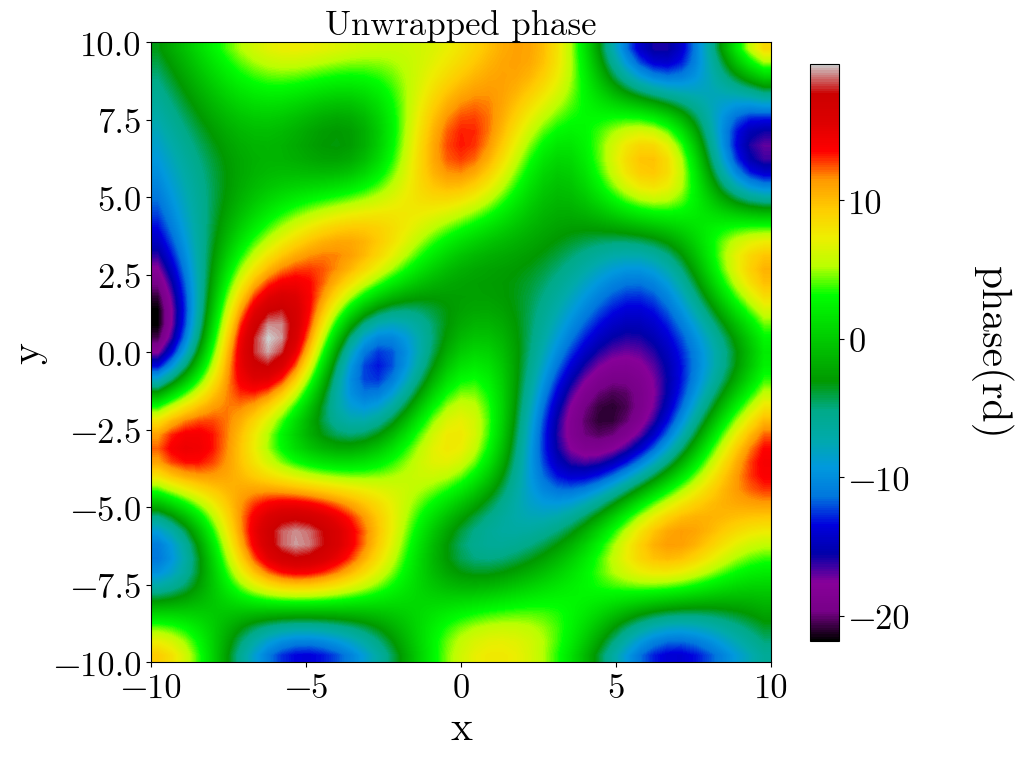

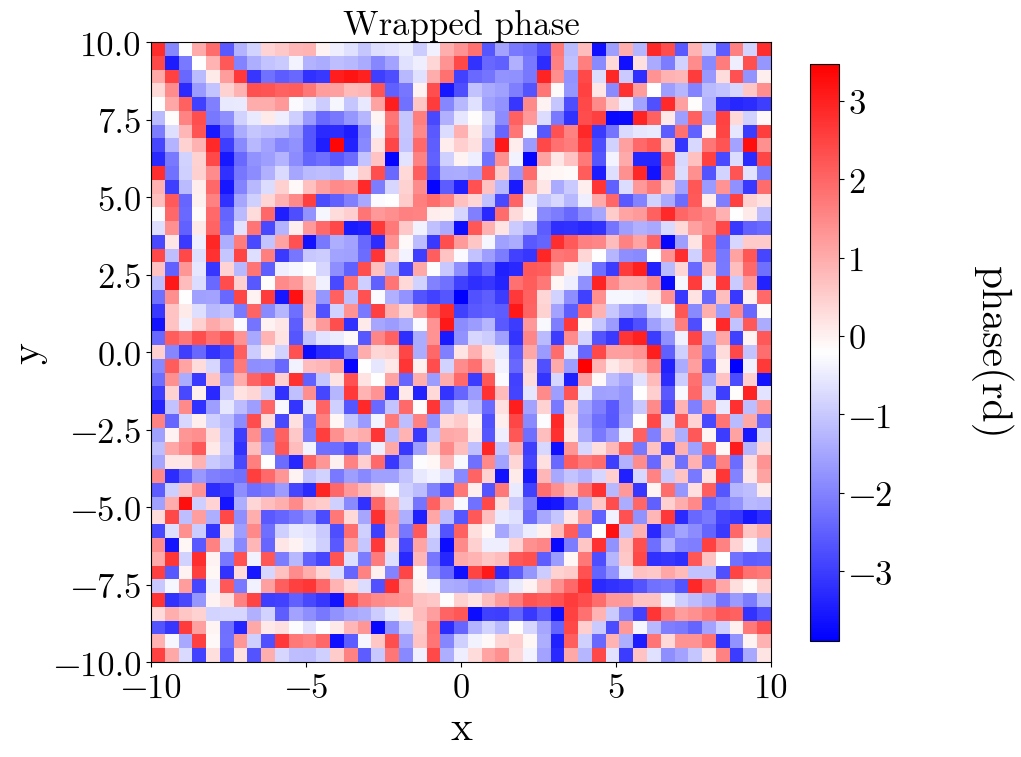

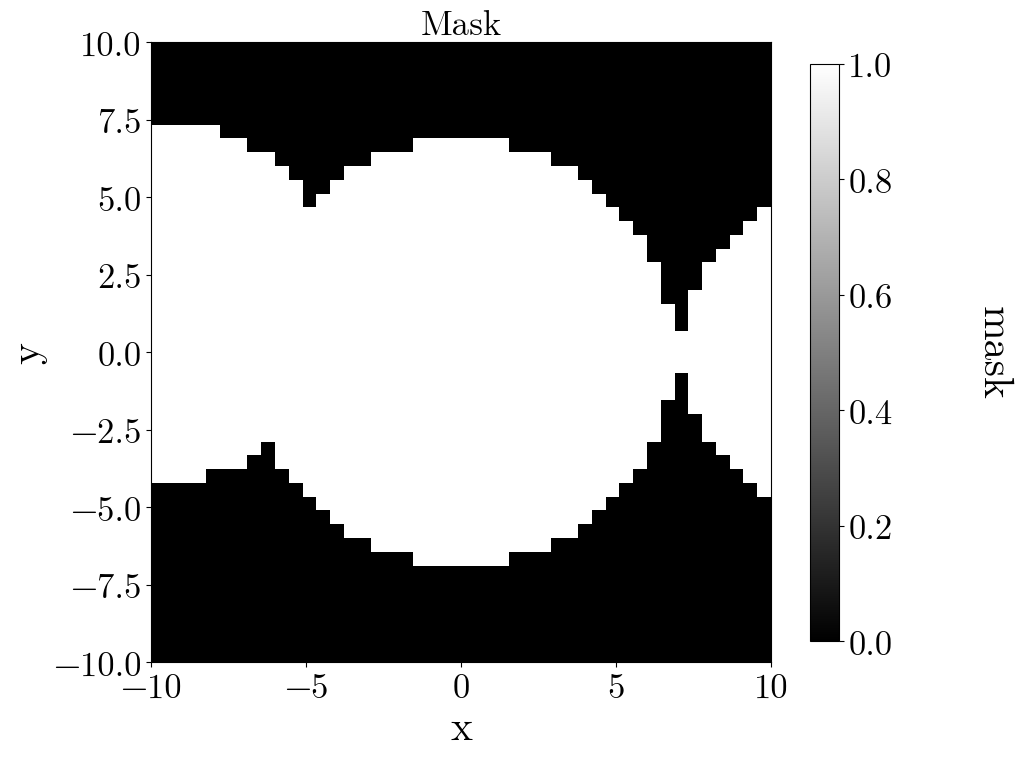

In [33]:
#ploting
plot_2D(phi,box,'phase(rd)','Unwrapped phase')
plot_2D(wrapped_phi,box,'phase(rd)','Wrapped phase',cmap='bwr',interpolate=False)
plot_2D(mask,box,'mask','Mask',cmap='gray',interpolate=False)

In [34]:
n_domains=5
data,grid=unpack_data(wrapped_phi,mask)
print(len(grid))

2108


In [35]:
domain,ghost,ghost_domain=domain_split(grid,n_domains)
dd=np.unique(domain)-domain[0]-1
gg=np.unique(ghost)-ghost[0]-1
print(len(gg)*1./len(dd))

0.19924098671726756


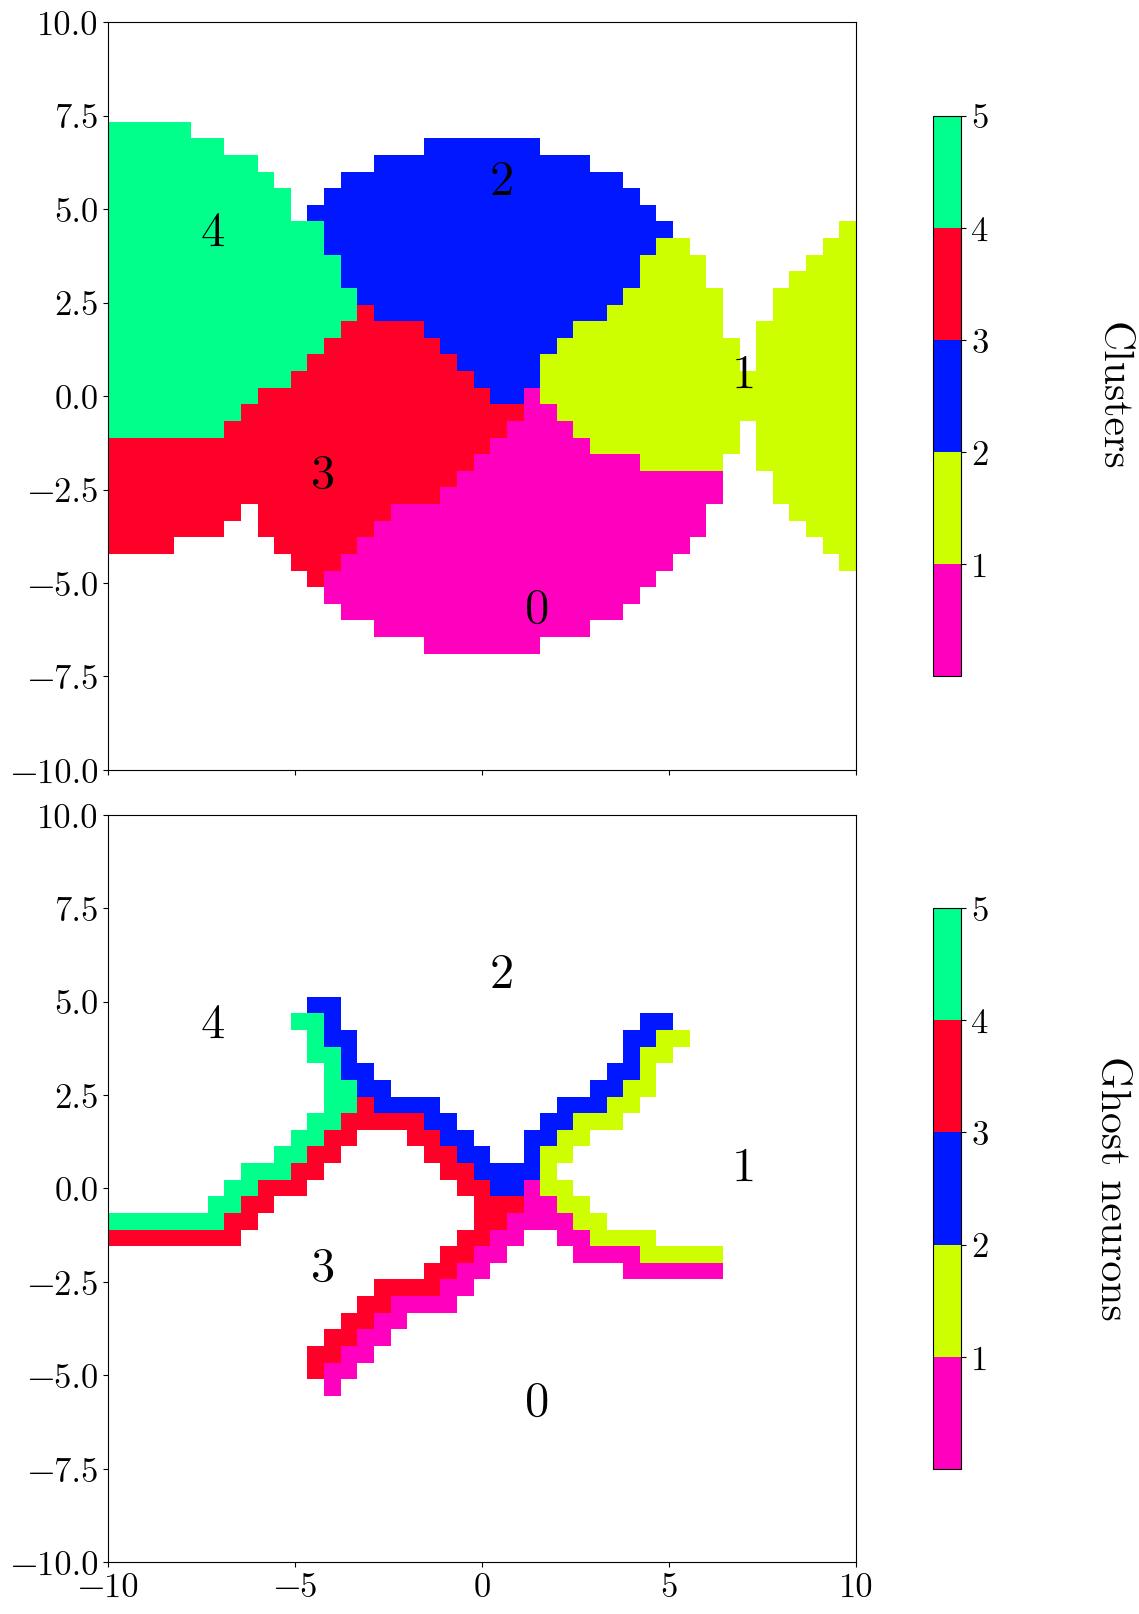

In [36]:
vals = np.linspace(0,1,n_domains)
random.Random(473776).shuffle(vals)
rcmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
split_domain,split_ghost,label=color_domains(wrapped_phi,grid,domain,ghost,ghost_domain)
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(2, 1, 1)
titled_plot_2D(split_domain,box,ax,'Clusters',interpolate=False,cmap=rcmap,min_cutoff=1e-6)
for i in range(n_domains):
    ax.text(label[i][0],label[i][1], str(i), transform=ax.transAxes,fontsize=35)
ax=fig.add_subplot(2, 1, 2)
titled_plot_2D(split_ghost,box,ax,'Ghost neurons',interpolate=False,cmap=rcmap,min_cutoff=1e-6)
for i in range(n_domains):
    ax.text(label[i][0],label[i][1], str(i), transform=ax.transAxes,fontsize=35)
plt.subplots_adjust(wspace=.1)
plt.subplots_adjust(hspace=.06)

In [37]:
sigma=15
sigma=np.ones(domain[0])*sigma
s=time.time()
w=np.empty(0)
phi_sync=np.empty(0)
wt=LMA_2D_block(data,grid,domain,ghost,ghost_domain,w,phi_sync,sigma=sigma,freg=1)
e=time.time()
print('Solve time',e-s,'s on a 48-core 2-GHz server.')

Stage:                  3 
Steps:                 16 
Lambda:        3.448665199330419e+19 
Error:         0.5384349910625358
Solve time 41.03427028656006 s on a 48-core 2-GHz server.


In [38]:
w=np.empty(0)
for k in range(n_domains):
    w=np.append(w,wt[k])


In [39]:
phi_s,phi_d,ghost_share,ghost_owner=init_sync_vector(grid,data,domain,ghost,ghost_domain,w,sigma=sigma)
phi_s,phi_d,ghost_share,ghost_owner=compress_sync_vector(phi_s,phi_d,ghost_share,ghost_owner)
phi_sync=LMA_sync(phi_s,phi_d,ghost_share,ghost_owner)


0 0.011121036140400402
6 0.010537311803266442


In [40]:
phi_RBFNN,d_phi_dx_RBFNN,d_phi_dy_RBFNN,d2_phi_dx2_RBFNN,d2_phi_dy2_RBFNN=repack_data(w,grid,domain,ghost,ghost_domain,wrapped_phi,phi_sync,sigma)

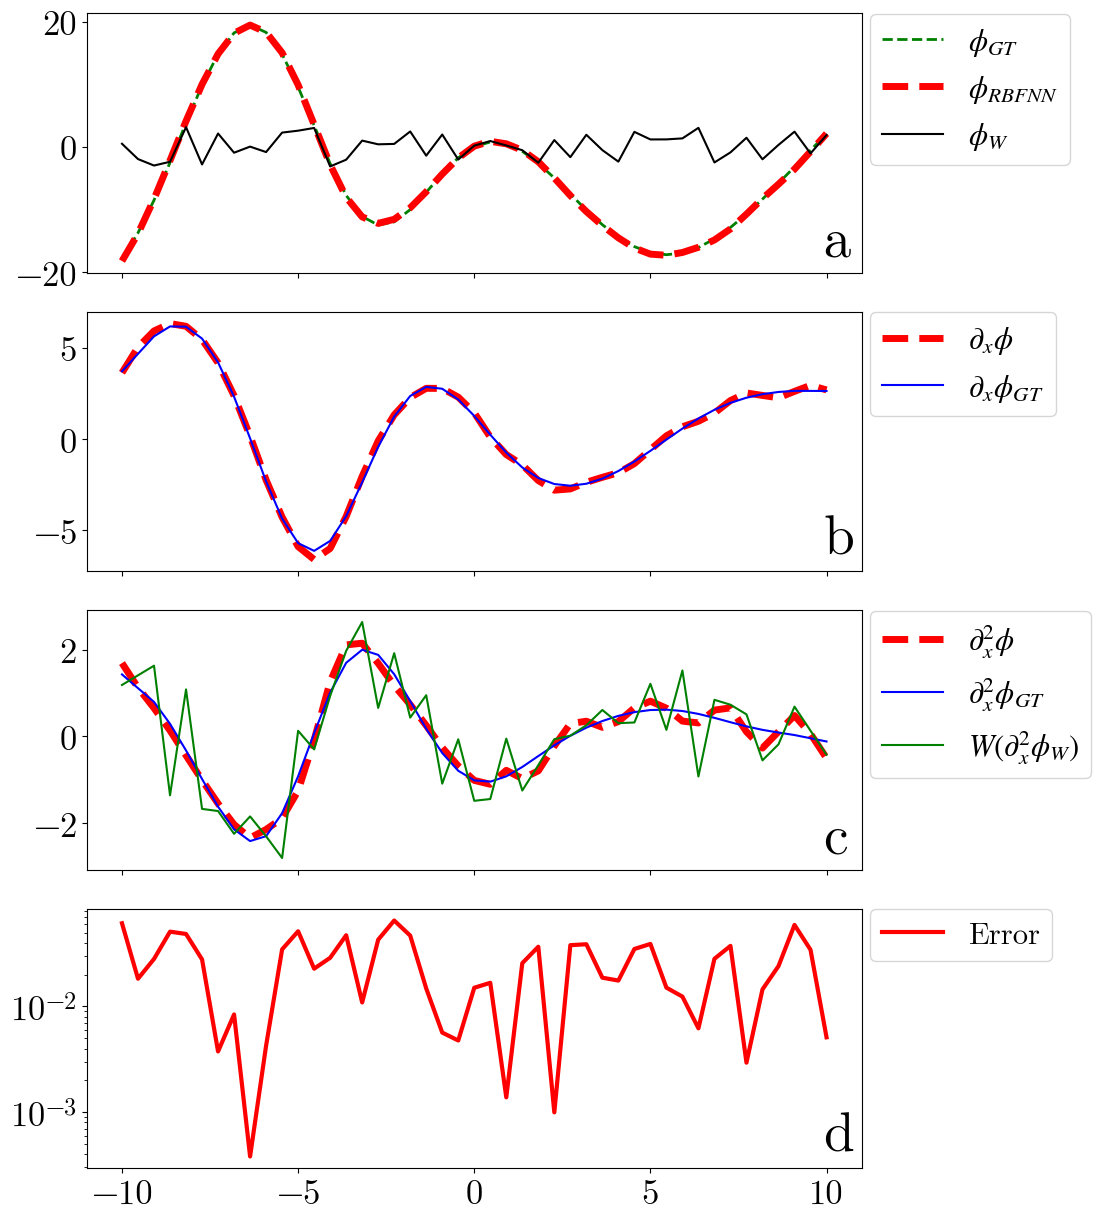

In [41]:
nx=len(phi[:,0])
mid_point=int(nx/2)
x=np.linspace(-xl,xl,nx)
#removed unknown phase bias from phi_RBFNN
phi_RBFNN-=np.average(phi_RBFNN[:,mid_point])*mask[:,mid_point]-np.average(phi[:,mid_point])
phi_RBFNN_slice=phi_RBFNN[:,mid_point]
phi_ref_slice=phi[:,mid_point]
wrapped_phi_slice=np.copy(phi_ref_slice)
wrapped_phi_slice=wrapped_phi[:,mid_point]
fig=plt.figure(figsize=(10,15))
ax=fig.add_subplot(4, 1, 1)
ax.label_outer()
WF(wrapped_phi_slice)
ax.plot(x,phi_ref_slice,label='$\phi_{GT}$',linewidth=2,linestyle='--',c='g')
ax.plot(x,phi_RBFNN_slice,label='$\phi_{RBFNN}$',linewidth=5,linestyle='--',c='r')
ax.plot(x,wrapped_phi_slice,label='$\phi_W$',c='black')
ax.text(.95,.025, 'a', transform=ax.transAxes,fontsize=40,  va='bottom')
ax.legend(bbox_to_anchor=(1.01, 1), ncol=1,loc='upper left', borderaxespad=.01,prop={"size":22})
ax=fig.add_subplot(4, 1, 2,sharex=ax)
ax.label_outer()
ax.plot(x,d_phi_dx_RBFNN[:,mid_point],label='$\partial_x\phi$',linewidth=5,linestyle='--',c='r')
ax.plot(x,DTC(phi[:,mid_point]),label='$\partial_x\phi_{GT}$',c='b')
ax.text(.95,.025, 'b', transform=ax.transAxes,fontsize=40,  va='bottom')
ax.legend(bbox_to_anchor=(1.01,1), ncol=1,loc='upper left', borderaxespad=.01,prop={"size":22})
ax=fig.add_subplot(4, 1, 3,sharex=ax)
ax.label_outer()
ax.plot(x,d2_phi_dx2_RBFNN[:,mid_point],label='$\partial_x^2\phi$',linewidth=5,linestyle='--',c='r')
ax.plot(x,D2T(phi[:,mid_point]),label='$\partial_x^2\phi_{GT}$',c='b')
ax.plot(x,WF(D2T(wrapped_phi[:,mid_point])),label='$W(\partial^2_x\phi_W)$',c='g')
ax.legend(bbox_to_anchor=(1.01,1), loc='upper left', borderaxespad=.01,prop={"size":22},ncol=1)
ax.text(.95,.025, 'c', transform=ax.transAxes,fontsize=40,  va='bottom')
ax=fig.add_subplot(4, 1, 4,sharex=ax)
ax.plot(x,1e-4+abs(phi_ref_slice-phi_RBFNN_slice)/2./np.pi*mask[:,mid_point],label='Error',c='r',linewidth=3)
ax.text(.95,.025, 'd', transform=ax.transAxes,fontsize=40,  va='bottom')
ax.legend(bbox_to_anchor=(1.01,1), loc='upper left', borderaxespad=.01,prop={"size":22},ncol=1)
ax.set_yscale('log')
plt.subplots_adjust(wspace=.04)
plt.subplots_adjust(hspace=.15)
plt.show()


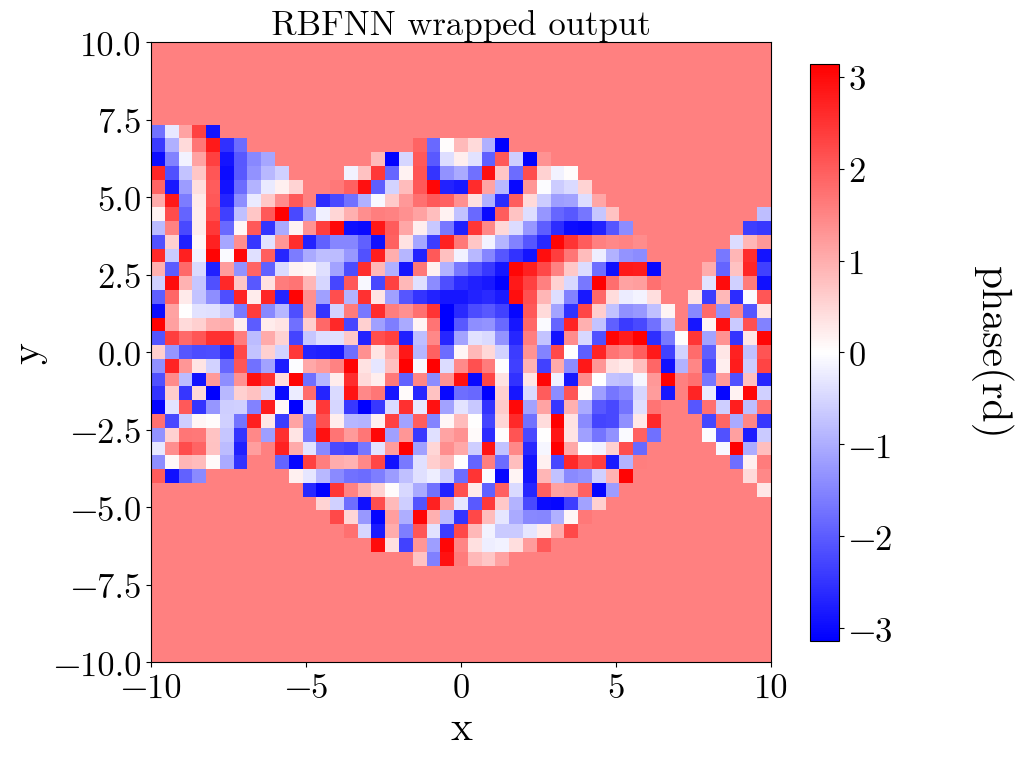

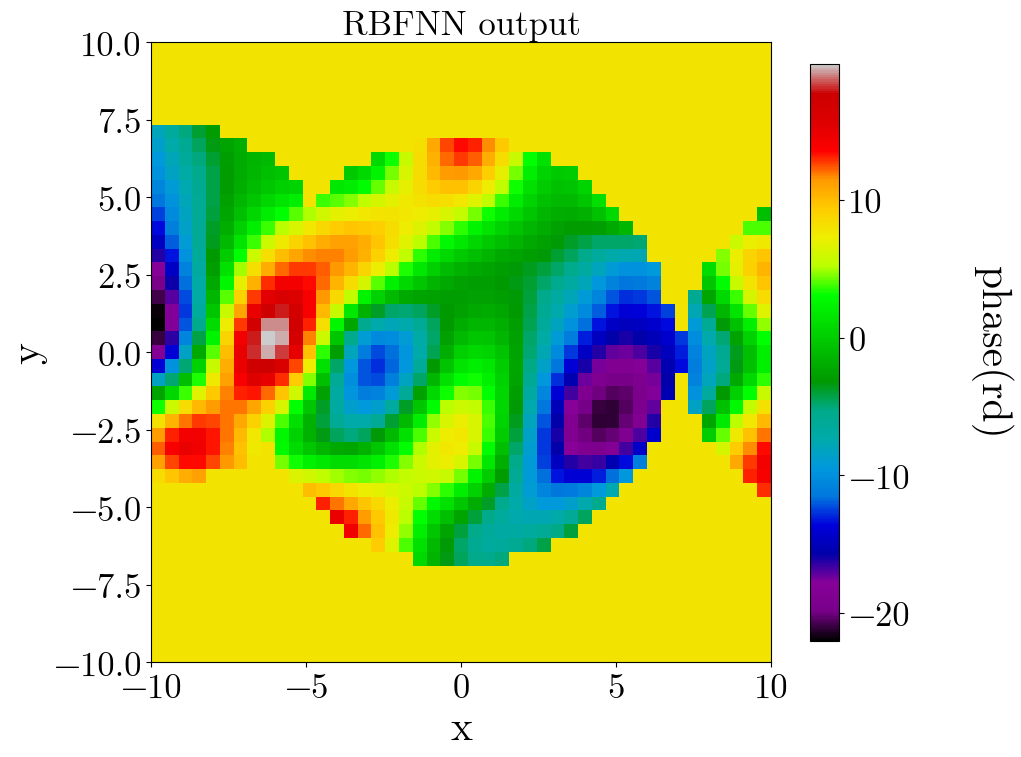

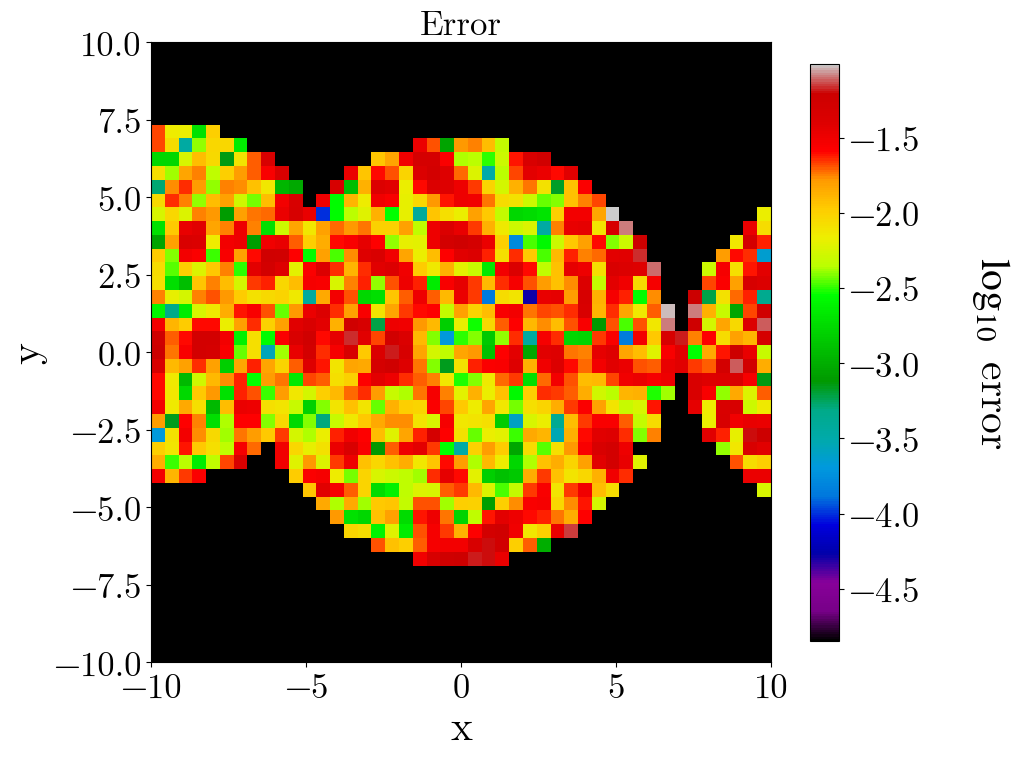

In [42]:
plot_2D(WF2D(phi_RBFNN),box,'phase(rd)','RBFNN wrapped output',cmap='bwr',interpolate=False)
plot_2D(phi_RBFNN,box,'phase(rd)','RBFNN output',interpolate=False)
error=np.log(np.abs(phi-phi_RBFNN)/2./np.pi)*mask/np.log(10)
plot_2D(error+np.amin(error)*(1-mask),box,'$\log_{10}$ error','Error',interpolate=False)
